In [156]:
import igraph as ig
from igraph import Graph
from Bio import SeqIO
import logging
from logging import debug, info, warning, error
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


class DBGraph(Graph):
    newid = 0 # allow for a fixed id per node
    k = 4 # we need to know the k-mer size (note: the length of the sequence per node is k-1)
    #igraph = None
    name = ""
    compacted = False
    contigs = []
    
    def __init__(self, name="", k=4):
        self.name = name
        self.k = k
        super().__init__(directed=True)

        
        
    
    
    # utility function to quickly retrieve the edge between two igraph nodes
    # this function should exist in igraph itself
    def edge(self, n1, n2):
        gl = self
        return gl.es[gl.get_eid(n1.index, n2.index)]
        
    """
   
   utility functions: adds the node sequences to the graph
   This one initialized a fresh node if the sequence is not already there.
    
    """
    
    def find_or_fresh_node(self, s):
        new_node = None
        g = self
        try:
            new_node = g.vs.find(sequence=s)     
        except: 
            if not new_node:
                new_node = g.add_vertex(name=s)
                new_node['id'] = self.newid # we need to keep a fixed id to reference nodes if other nodes are deleted
                new_node['sequence'] = s
                new_node['label'] = str(new_node.index) +':'+ s
                new_node['visited'] = False
                new_node['compacted'] = False
                new_node['coverage'] = 1
                new_node['sum'] = 0
                new_node['dist'] = 0
              
            assert new_node, 'Failed to create new node!'
            self.newid += 1 
        return new_node
            
    
    def add(self, s1, s2):
        if self.compacted:
            raise Exception("New nodes cannot be added to a compacted graph.")
        g = self
        n1 = self.find_or_fresh_node(s1) 
        n2 = self.find_or_fresh_node(s2)     
               
        i1 = n1.index
        i2 = n2.index
        debug ("adding edge"+str(i1)+" --> "+str(i2))
        eid = None
        try: # the edge could be there already
            eid = g.get_eid(i1,i2)
            g.es[eid]["coverage"] += 1 ## in a true DeBrujn Graph the edges carry the multiplicity!
        except: # the edge is new
            g.add_edges([(i1,i2)])
            eid = g.get_eid(i1,i2)
            g.es[eid]["coverage"] = 1 
    
    def add_kmer(self,kmer):
        assert len(kmer) == self.k, "kmer sequence must have length k" 
        self.add(kmer[0:self.k-1], kmer[1:self.k])
     
    def add_from_file(self, file):       
        for record in SeqIO.parse(file, 'fasta'):
            i = 0
            while i < (len(record.seq) - self.k + 1):
                self.add_kmer(record.seq[i:i+self.k])
                i += 1
            

    def get_node0(self):
        return Node(graph=self, id=0)
    
    """
    compact the graph by compressing linear stretches of nodes into a single node
    and deleting the redundant nodes
    conserves coverage by computing the average coverage for the compacted nodes
    and stores it in the node
    That leads to a much more compact representation and reduces the effort of 
    subsequenct filtering and contig generation
    Note that no more k-mers can be added after compaction, because the original 
    k-mers can no longer be found by dictionary lookup
    """
    
    
    def compact(self):
        if self.compacted:
            raise Exception("Compaction can only be run once per graph")
        self.compacted = True
        ## look for simple 0 start nodes first
        ## only nodes with outdegree can be compacted        
        # for ni in nset0: print(ni["name"])
        i = 0
        # update set of not yet compacted nodes after each iteration
        while True: # this needs to be done this way, otherwise the set is not updated correctly    
            nset0 = self.vs.select(_outdegree_eq = 1, compacted = False)
            debug(str (i) + ': len(nset0)' + str(len(nset0)) )
            if len(nset0) < 1:    
                info('no more compactable stretches')
                break
            n = nset0[0]
            i += 1
            ### we want to walk to the left-most position, before engaging with the compaction
            n['visited'] = True
            while (n.indegree() == 1 and n.predecessors()[0].outdegree() == 1 and not n.predecessors()[0]['visited']):
                # move left                
                n = n.predecessors()[0]
                n['visited'] = True # avoid infinite loop
                debug('seeking left' + n['sequence'] )
            for noob in self.vs: noob['visited'] = False # set it back
            debug ("Start compacting: " + str(n) + str(n.outdegree()))         
            assert  n.outdegree() == 1 and (not n['compacted']), "We hit an already compacted node!" # this should never happen because of select statement
            first_time = True
            # don't take this node again
            # we are going to simply delete the neighbors, there is only one dircet neighbor
            # but we also need to check if the next node is balanced
            n['compacted'] = True # mark this node as compacted, so it won't come up again
            n['sum'] = 0 # compacted nodes store their coverage themselves, sum of coverages
            n['dist'] = 0 # distance forward to next "junction" ahead
            
            ## control id, keeping the originally assigned ids in the nodes 
            cid = n["id"]
            
            ## This is the actual compaction for node n 
            while True: 
                n = self.vs.select(id = cid)[0] 
                ## when deletng nodes, weird things kan happen, so make sure we got the same node as before
                assert n, "node must stay the same under one iteration" 
                ## exit condition: we don't have exactly 1 successor, or the next node has 
                ## multiple incoming nodes
                if (n.outdegree() != 1 or n.successors()[0].indegree() != 1):
                    debug ('--------------   finished with node ' + str(n))
                    break    
                
                    
                succ = n.successors()[0] # node is linear, so we are sure
                ### don't follow only self-reference:
                if n == succ: 
                    debug('------------------ hit a self reference, finished')
                    break
                if succ['visited']:
                    debug ('------------------ hit a loop here')
                    break
                if n in n.successors() or n in succ.successors():
                    debug('------------------- we hit a loop, finished')
                    break
                
                ## Only the very first node in our path needs to keep the full k-mer, that is a node with in_degree 0
                ## All other need to be clipped now
                if n.indegree() > 0 and first_time:
                        # otherwise we would artificially prolong the sequence
                        # indegree 0 nodes always keep their sequence
                    n['sequence'] = n['sequence'][self.k-2:]
                    first_time = False
                else: 
                    first_time = False # but only once, otherwise we'd chop off the whole sequence
                    
                debug("really compacting " + n['sequence'] + ' --> ' + succ['sequence'] + str(n))
                n['visited'] = True
                eid = self.get_eid(n.index, succ.index) # geet the edge id
                ## add edges to all succ.successors to this node
                for s in succ.successors():
                    self.add_edges([(n.index,s.index)]) ## add a new edge, 
                    new_eid = self.get_eid(n.index, s.index) ## and get the index of the edge we just made
                    ## we need to copy the coverage attribute over, 
                    ## so get the edge connecting 
                    ## successor to its next successor
                    succ_eid = self.get_eid(succ.index, s.index)
                    self.es[new_eid]['coverage'] = self.es[succ_eid]['coverage']  # copy coverage            
                ## get the successors single character and add to node sequence
                if succ["compacted"]:
                    ## add the sequence of the compacted node, it is already compacted
                    n["sequence"] += succ["sequence"]
                    n["sum"] += succ["sum"]
                    n['dist'] += succ['dist']   
                else:
                    n["sequence"] += succ["sequence"][-1:]
                    if n['sum'] == None:
                        error ('this should never happen: ' + str(n))
                    assert self.es[eid]['coverage'], "Every edge should have a coverage attribute"
                    assert n['sum'] != None, "we set the coverage attribute already"
                    n['sum'] += self.es[eid]['coverage'] # here the coverage is in the edge
                    n['dist'] += 1 # now we have made only a single step                   
                n["name"] = n["sequence"]    
                n['label'] = '['+ str(n.index) +'] '+ n['sequence'] 
                ## now delete the successor and the edge
                eid = self.get_eid(n.index, succ.index)
                self.delete_edges(eid)
                debug ("deleting: " + succ['name'])
                self.delete_vertices(succ.index)
                
        ## Now the compaction is complete, but we still have sum and dist per node, but not coverage, so we need to update
        ## the compacted nodes in a last sweep over all compacted nodes
        for n in self.vs: n['visited'] = False 
        for n in self.vs.select(compacted = True):
            if (n['dist'] == 0): 
                n['coverage'] = 1
                n['compacted'] = False ## these nodes were not really compacted, there were just marked 
            else:
                n['coverage'] = n['sum']/n['dist']
        
            
  
    def viz(self):
        g = self
        layout = g.layout("kk")
        color_dict = {True: "lightgreen", False: "tomato"}
        colors = [color_dict[c] for c in g.vs["compacted"]]
        shapes = []
        visual_style = {}
        visual_style["edge_width"] = [0.5 * int(coverage) for coverage in g.es["coverage"]]
        visual_style["vertex_size"] = [20 * int(coverage) for coverage in g.vs["coverage"]]
        for s in g.vs.indegree():
            if s == 0:
                shapes.append("rectangle")
            else:
                shapes.append("circle")
        g.vs['label'] = list(map(lambda x: str(x.index)+':'+x['sequence'], g.vs))        
        return(ig.plot(g, bbox=(0, 0, 400, 400), vertex_color=colors, 
                       vertex_shape=shapes, vertex_label_dist = -0.5, layout=layout, **visual_style ))

        

   
    
    ## utility function to get the best node, strategy:
    ## ignore self reference
    ## 0. if no further node: None
    ## 1. if outdegree == 1, get the node
    ## 2. if outdegree > 0, prioritize:
    ##   1) get not visited node with highest coverage
    ## the user is responsible to mark node as visited if it is used
    ## we don't want to hit on an infinite loop, but if a visited node has an unvisited next node
    ## it could still be part of an Eulerian walk
    
    """
    TODO: This function has much room for improvement. It may break up a perfectly Eulerian
    walk through the graph. Find an example of such a Eulerian graph topology. How could this be
    improved?
    """
    def get_next_node(self, n):
        
        if (n.outdegree() < 1): return None
        if (n.outdegree() == 1):
            nn = n.successors()[0] ## there is only one, return it, but only if it is not self referential
            if n == nn: # or nn['visited']: # self reference or already visited
                ### this is sub-optimal, we cannot solve graph named "double loop" below
                ### like this properly, at least it protects against infinite loop
                ### in order to resolve double loops and alternative paths, we have to return 
                ### nn in case it has an edge that we haven't visited yet
                return None
                if not all(list(map(lambda y: y['visited'] or nn == y, nn.successors()))):
                    # checks, if of successor's successors has not been visited yet
                    # slightly better, but still not optimal, one would want to define a 
                    # coverage threshold, at this point. However, such threshold should be
                    # adaptive, depending on global or local coverage
                    # Idea: calculate local coverage at the environment,
                    # to use a node twice, each edge to traverse should have at least similar (e.g. 1/2?) coverage
                    # compared to the local environment
                    return nn
                else: 
                    return None
        
        nset = n.successors()
        tmp = list(filter (lambda x: not x['visited'], nset))
        if len(tmp) > 0: 
            nn = sorted(tmp, key=lambda node: (n.outdegree(), node['coverage'], self.edge(n, node)['coverage'], len(node['sequence'] )), reverse=True)[0] 
            if n == nn: # self reference
                return None
            else:
                return nn
        else:    
            tmp = nset         
            tmp = list(filter(lambda x: (not all(list(map(lambda y: y['visited'] or x == y, x.successors())))), tmp))
                     
            if len(tmp) < 1: 
                return None
            else:
                debug ('has unvisited next: ' + str(tmp))   
                tmp = sorted(tmp, key=lambda node: (node['coverage'], self.edge(n, node)['coverage'], len(node['sequence'] )), reverse=True) 
        
                nn = tmp[0]
                if n == nn: # self reference
                    return None
                else:
                    return nn
    
    """
    make a walk through the graph, given the start node
    """
    def walk(self, n):
        sequence = n['sequence']
        n['visited'] = True
        n1 = n
        debug('walk: ' + n1['name'] + n1['sequence'])
        while self.get_next_node(n1):
            
            n1 = self.get_next_node(n1)
            debug('walk: ' + n1['name'])
            n1['visited'] = True
            if n1['compacted']:
                sequence += n1['sequence']
                debug ('seq: '+n1['sequence'])
            else:
                sequence += n1['sequence'][self.k-2]
                debug ('seq: '+n1['sequence'][self.k-2])
        info ('Done')        
        return sequence        
                
        
    
    
        
    ### The gredy assembly is the simplest possible heuristics and works on the compacted graph
    ### With greedy bubble correction and at every junction, follow the path of highest coverage
    ### No variants will be detected this way
    ### Dangling short ends will be cut off if they are shorter than min_contig_len, and there is another 
    ### path > 2*k ahead, even if they have higher coverage 
    ### If a repeat (a node that has already been visited) is hit with distance < min_contig_len, the contig will be dropped 
    #   - get all start nodes, easy ones first until all nodes have been visited
    def assemble(self):
       
        contigs = []
        min_contig_len = self.k ## very lenient, could be increased but ok for toy examples
        
        # get optimal start nodes first: optimal start nodes are those with indegree 0 and not visited
        counter = 0
        nset0 = self.vs.select( visited = False, _indegree = 0 )
        
        while counter <= len(nset0): # protect against infinite loop
            nset = self.vs.select(visited = False, _indegree = 0)
            # we could also sort the nodeset to refine our strategy further but we don't need that now
            if len(nset) < 1: break
            contig = self.walk(nset[0])
            if len(contig) >= min_contig_len:
                contigs.append(contig)
        
        # do the same for remaining other unvisited nodes
        nset0 = self.vs.select( visited = False)
        
        while counter <= len(nset0): # protect against infinite loop
        
            nset = self.vs.select(visited = False)
            # we could also sort the nodeset to refine our strategy further
            # as we might end up being somewhere in a loop, we could as well start with
            # the longest node
            nset = sorted(nset, key = lambda x: len(x['sequence']), reverse = True)
            if len(nset) < 1: break
            contig = self.walk(nset[0])
            if len(contig) >= min_contig_len:
                contigs.append(contig)
        
        self.contigs = contigs
        return contigs
        
        
        
        
        
    
    """
    utility funciton to calculate the coverage per graph
    assume there is a real path between nodes
    """
    def get_path_coverage(self, path):
        pathsum = 0
        pathlen = 0
        for i in range(len(path)):
            n = self.vs[path[i]]
            if (n['compacted']):
                pathsum += n['sum']
                pathlen += n['dist']
            else:
                if i < len(path)-1:
                    pathsum += self.edge(self.vs[path[i]], self.vs[path[i+1]])['coverage']
                    pathlen += 1
                    
        if (pathlen > 0): 
            return pathsum/pathlen
        else:
            return 0                 
                            
    ## simple bubble removal strategy:
    ## a bubble starts at a node with outdegree > 1
    ## it ends if the paths join again
    ## if the paths join at all
    ## if there are alternative paths to the confluent node, AND all nodes in a path have outdegree == 1
    ## then we have a real bubble: remove the nodes in the path(s) with lowest coverage
    ## however, we ignore the case for now that there could be divergent paths emerging from a lower 
    ## coverage bubble. 
    def remove_bubbles(self):
        max_look_ahead = 100 # maximum number of nodes to look ahead for a junction
        # first check if there is a bubble at all
        # we heavily use graph and set operations here
        nset0 = self.vs.select(_outdegree_gt = 1) # the maximum number of nodes to visit        
        counter = 0       
        while (counter < len(nset0)): # max number of iterations possible because we only delete nodes
            counter = counter + 1
            ## we have to update our nodes each time, because nodes could have been deleted already
            nset = self.vs.select(_outdegree_gt = 1)
            if len (nset) < 1: break
            n = nset[0]
            nhoods = self.neighborhood(n.successors(), order=max_look_ahead, mode="out") ## get nodeset in neighborhoods
            for i in range(len(nhoods)):
                for j in range(i+1, len(nhoods)):
                    ## if the intersections are non-empty, there is a confluent node
                    confluent_node = isect(nhoods[i],nhoods[j])
                    if (confluent_node):
                        info (str(counter) + ':' +' bubble detected:' + n['name'] +' ---> ' + self.vs[confluent_node]['name'])
                        paths = list(map(lambda x: self.get_shortest_paths(x,confluent_node)[0], n.successors()))
                        paths = sorted(paths, key= lambda x: (g.get_path_coverage(x),len(x))) # order paths by coverage, then by length
                        debug(str(paths))
                        keep_this = paths.pop()
                        for path in paths:
                            if n.index in path: continue ## this is a loop, we cannot deal with this case yet
                            del_me = set(path) - set(keep_this) # get a set with shared nodes removed 
                            # this guarantees also that we do not accidentially delete nodes that are still needed
                            # one could decide to only delete linear nodes
                            del_me = list(filter(lambda x: self.vs[x].outdegree() == 1 , del_me))
                            ## if the graph was compacted already this would delete only compacted nodes
                            # del_me = list(filter(lambda x: self.vs[x].indegree() == 1 , del_me))
                            
                            info ("deleting the following nodes: "+ str(del_me))
                            self.delete_vertices(del_me) # that will also clean the edges
    
    
    
        
def isect(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    if len(lst3) < 1: 
        return None
    else:
        return lst3[0]
        
    
class Node:
    id = 0
    graph = None
    inode = None
    def __init__(self, graph, id=None, sequence=None):
        self.graph = graph
        if sequence:
            self.inode = graph.vs.find(sequence=sequence)
        else: 
            if id != None:
                self.inode = graph.vs[id]               
        self.id = self.inode['id']
        
    def indegree(self):
        return self.inode.indegree()
    
    def outdegree(self):
        return self.inode.outdegree()

In [157]:
g = DBGraph('hey joe')

#g.add_kmer('tttt')
## bubble graph
g.add('abb','bbb')

DEBUG:root:adding edge0 --> 1


DEBUG:root:adding edge0 --> 1
DEBUG:root:adding edge1 --> 2
DEBUG:root:adding edge2 --> 3
DEBUG:root:adding edge3 --> 4
DEBUG:root:adding edge3 --> 5
DEBUG:root:adding edge5 --> 6
DEBUG:root:adding edge6 --> 7
DEBUG:root:adding edge6 --> 8
DEBUG:root:adding edge8 --> 9
DEBUG:root:adding edge9 --> 10
DEBUG:root:adding edge4 --> 10
DEBUG:root:adding edge1 --> 11
DEBUG:root:adding edge1 --> 11
DEBUG:root:adding edge1 --> 11
DEBUG:root:adding edge11 --> 12
DEBUG:root:adding edge11 --> 12
DEBUG:root:adding edge12 --> 13
DEBUG:root:adding edge12 --> 13
DEBUG:root:adding edge13 --> 10
DEBUG:root:adding edge10 --> 14


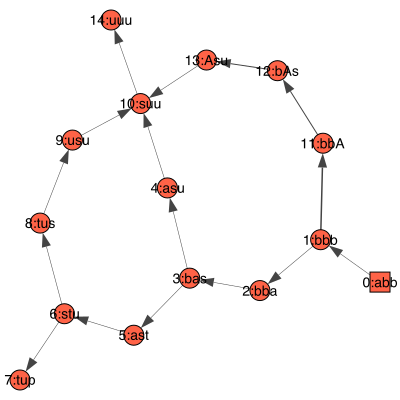

In [158]:
g = DBGraph('hey joe')

#g.add_kmer('tttt')
## bubble graph
g.add('abb','bbb')
g.add('bbb','bba')
g.add('bba','bas')
g.add('bas','asu')
g.add('bas','ast')
g.add('ast','stu')
g.add('stu','tup')
g.add('stu','tus')
g.add('tus','usu')
g.add('usu','suu')

g.add('asu','suu')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbA','bAs')
g.add('bbA','bAs')
g.add('bAs','Asu')
g.add('bAs','Asu')
g.add('Asu','suu')
g.add('suu','uuu')

## alternative start and end nodes
## g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("XAT","ATG")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")

g.viz()


DEBUG:root:0: len(nset0)10
DEBUG:root:Start compacting: igraph.Vertex(<__main__.DBGraph object at 0x7f8358d645e0>, 0, {'name': 'abb', 'id': 0, 'sequence': 'abb', 'label': '0:abb', 'visited': False, 'compacted': False, 'coverage': 1, 'sum': 0, 'dist': 0})1
DEBUG:root:really compacting abb --> bbbigraph.Vertex(<__main__.DBGraph object at 0x7f8358d645e0>, 0, {'name': 'abb', 'id': 0, 'sequence': 'abb', 'label': '0:abb', 'visited': False, 'compacted': True, 'coverage': 1, 'sum': 0, 'dist': 0})
DEBUG:root:deleting: bbb
DEBUG:root:--------------   finished with node igraph.Vertex(<__main__.DBGraph object at 0x7f8358d645e0>, 0, {'name': 'abbb', 'id': 0, 'sequence': 'abbb', 'label': '[0] abbb', 'visited': True, 'compacted': True, 'coverage': 1, 'sum': 1, 'dist': 1})
DEBUG:root:1: len(nset0)9
DEBUG:root:Start compacting: igraph.Vertex(<__main__.DBGraph object at 0x7f8358d645e0>, 1, {'name': 'bba', 'id': 2, 'sequence': 'bba', 'label': '2:bba', 'visited': False, 'compacted': False, 'coverage': 1, 

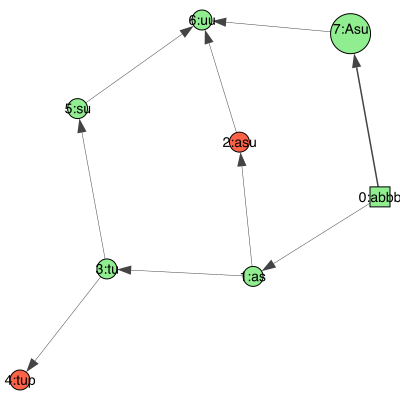

In [159]:
g.compact()
g.viz()

In [139]:
g = DBGraph("cycle")
# cyclic
g.add("ZAP","APZ")
g.add("APZ","PZA")
g.add("PZA","ZAP")
## this must not give into infinite loop
g.compact()
g.assemble() # output: ['ZAPZA']

INFO:root:no more compactable stretches
INFO:root:Done


['ZAPZA']

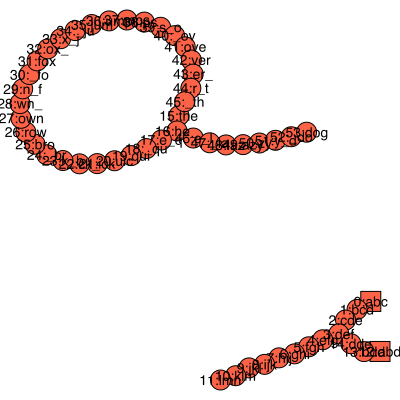

In [140]:
# test construction from file
g = DBGraph('file')
g.add_from_file('test.fasta')
g.viz()

INFO:root:no more compactable stretches


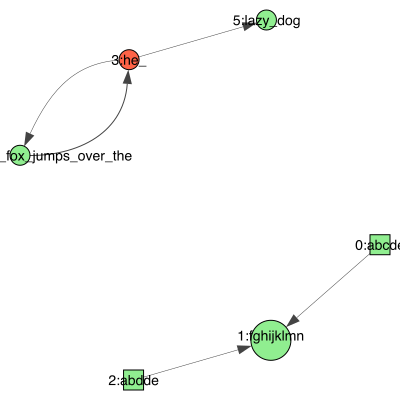

In [141]:
g.compact()
g.viz()

In [142]:
g.remove_bubbles()
g.assemble() ## [Seq('12345678'), Seq('abcdefghijklmnopqrstuvwXYZ')] 
# output: [Seq('abcdefghijklmn'),
# Seq('abdde'),
# Seq('quick_brown_fox_jumps_over_the_lazy_dog')]
# no bubble will be deleted because it is indeed a loop

INFO:root:1: bubble detected:he_ ---> lazy_dog
INFO:root:deleting the following nodes: []
INFO:root:Done
INFO:root:Done
INFO:root:Done


[Seq('abcdefghijklmn'),
 Seq('abdde'),
 Seq('quick_brown_fox_jumps_over_the_lazy_dog')]

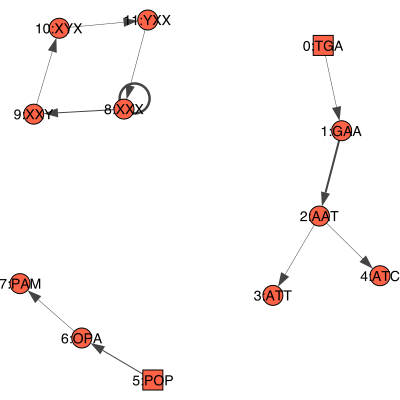

In [143]:
    

    
g = DBGraph('test more stuff')
g.add("TGA","GAA")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")

g.add("AAT","ATT")
g.add("AAT","ATC")

# short linear graph
g.add("POP","OPA")
g.add('POP','OPA')
g.add("OPA","PAM")



## self repeat + cyclic graph
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXY")
g.add("XXX","XXY")

g.add("XXY","XYX")
g.add("XYX","YXX")
g.add("YXX","XXX")
g.viz()

In [144]:
g.compact()
g.assemble() # should give: ['TGAATT', 'POPAM', 'XXXYXX']
    
    

INFO:root:no more compactable stretches
INFO:root:Done
INFO:root:Done
INFO:root:Done
INFO:root:Done


['TGAATT', 'POPAM', 'XXXYXX']

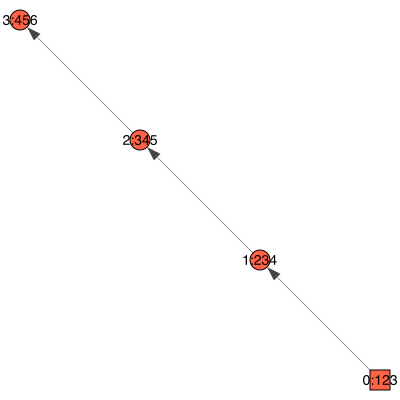

In [145]:
g = DBGraph('hey joe')
g.add('123','234')
g.add('234','345')
g.add('345','456')
g.viz()


In [146]:
g.assemble() # simple graphs can be assembled directly: 123456


INFO:root:Done


['123456']

INFO:root:no more compactable stretches


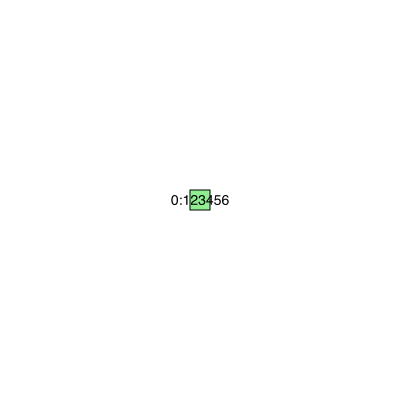

In [147]:
g.compact()
g.viz()






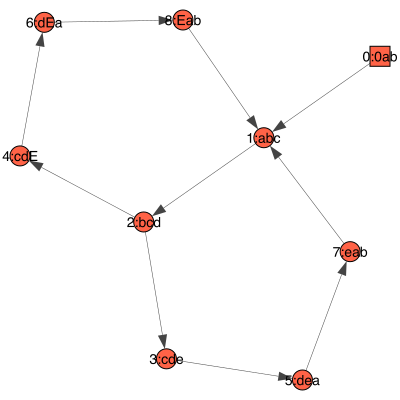

In [148]:
g = DBGraph('double loop')
g.add('0ab','abc')
g.add('abc','bcd')
g.add('bcd','cde')
g.add('bcd','cdE')
g.add('cde','dea')
g.add('cdE','dEa')
g.add('dea','eab')
g.add('dEa','Eab')
g.add('eab','abc')
g.add('Eab','abc')
g.viz()


INFO:root:no more compactable stretches


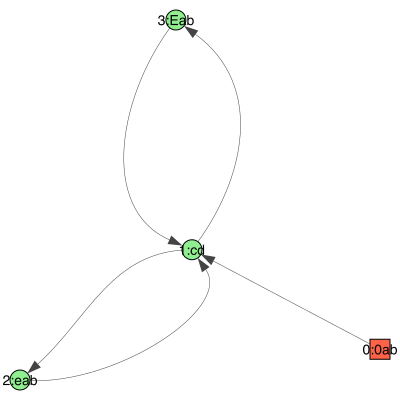

In [149]:
g.compact()
g.viz()

INFO:root:1: bubble detected:cd ---> eab
INFO:root:deleting the following nodes: []


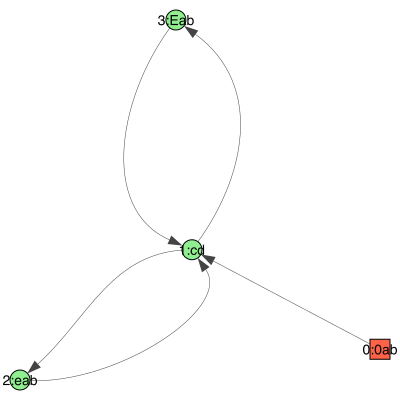

In [150]:
g.remove_bubbles()
g.viz()

In [151]:
g.assemble() # should give: ['0abcdeabcdEab']

INFO:root:Done


['0abcdeabcdEab']